### Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 7938</pre>

In [1745]:
# student 1: Israel 7938
# student 2: Eran 6215
# student 3: Avihai 2474
# student 4: Almog 8269
# student 5: Liron 5068
# student 6: Matan 9999

## Part 2 - Experiments
You could add as many code cells as needed

In [1746]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [1747]:
train_set = pd.read_csv('titanic_train.csv')
test_set = pd.read_csv("titanic_test.csv")

In [1748]:
train_set.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [1749]:
test_set.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


In [1750]:
#Men
survivedMan = train_set[(train_set['Sex'] == 1) & (train_set['Age'] > 18) & (train_set['Survived'] == 1)]
survivedManCount = len(survivedMan)
print("Survived man :",survivedManCount)

#Women
survivedWomen = train_set[(train_set['Sex'] == 0) & (train_set['Age'] > 18) & (train_set['Survived'] == 1)]
survivedWomenCount = len(survivedWomen)
print("survived women:",survivedWomenCount)
#Kids
survivedKids = train_set[(train_set['Age'] <= 18) & (train_set['Survived'] == 1)]
survivedKidsCount = len(survivedKids)
print("survived kids",survivedKidsCount)

survivedCount = len(train_set[train_set['Survived'] == 1])
print("survivels: ",survivedCount)

Survived man : 69
survived women: 156
survived kids 56
survivels:  281


In [1751]:
train_set.isnull().sum() 

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64

## Visualization

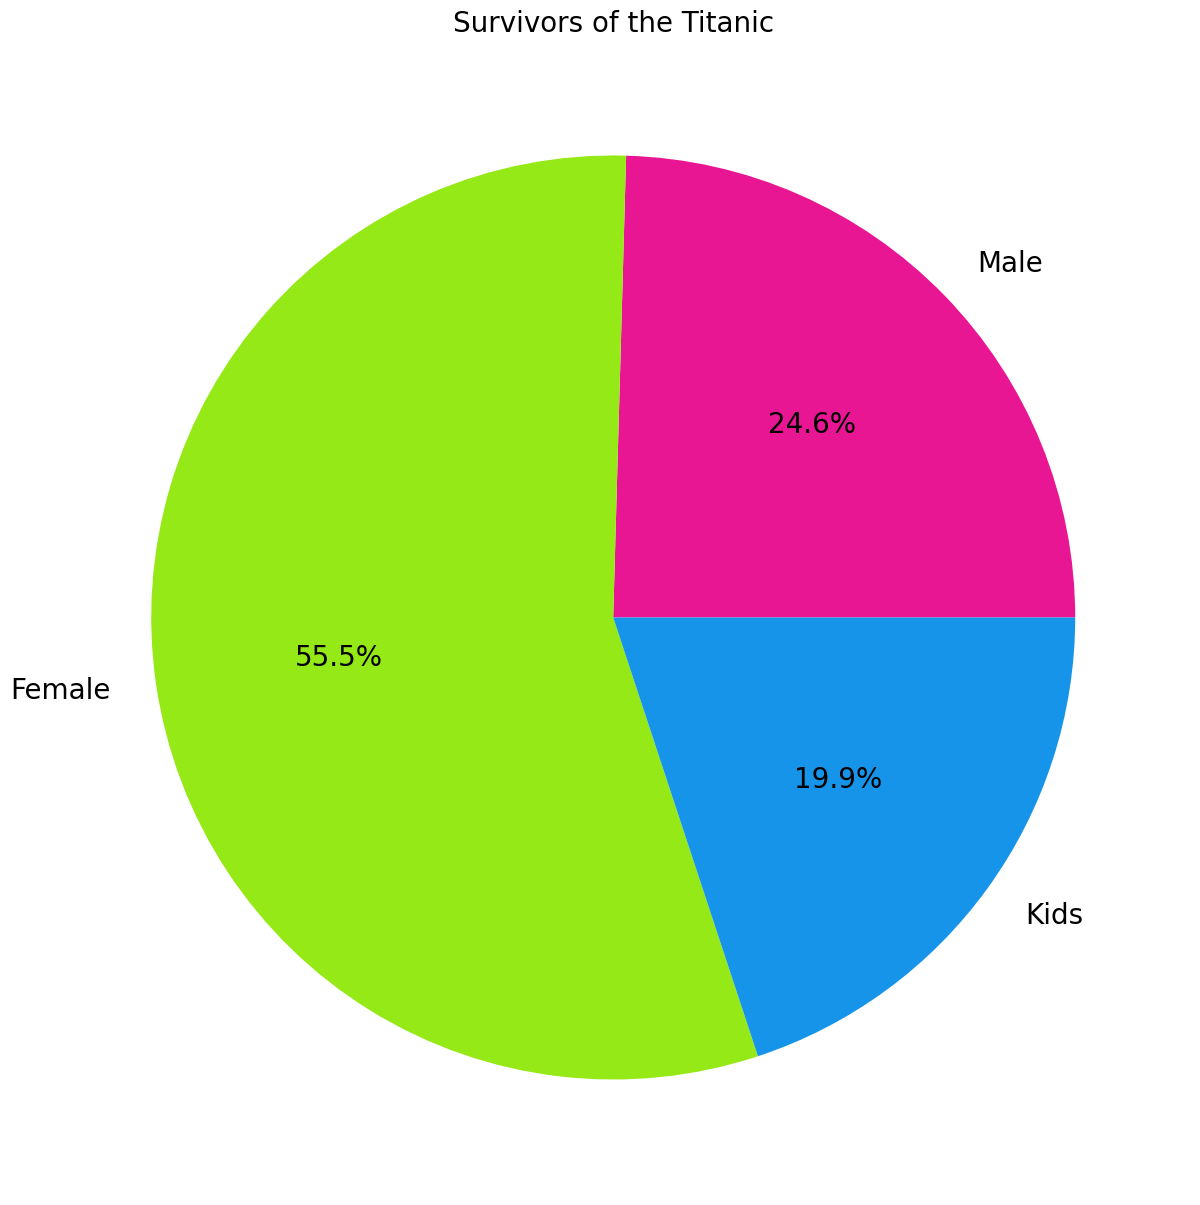

In [1752]:
population = [survivedManCount,survivedWomenCount,survivedKidsCount]
labels = ['Male', 'Female','Kids']
colors = ['#E91694', '#94E916', '#1694E9']
fig,ax = plt.subplots(figsize=(20, 15))
ax.pie(population,labels = labels,autopct='%1.1f%%',colors=colors, textprops={'fontsize': 20})
plt.title('Survivors of the Titanic', fontsize=20)
fig.patch.set_facecolor('white')
plt.show()

In [1753]:
# Creating a dataframe for the pie plot using the given parameters
def createPieTable(survivedManCount, survivedWomenCount, survivedKidsCount, survivedCount):
        data = {'Category': ['Male', 'Female', 'Kids', 'Total'],
                'Survived': [survivedManCount, survivedWomenCount, survivedKidsCount, survivedCount]}
        Survivors1 = pd.DataFrame(data)
        Survivors1['Percentage'] = Survivors1['Survived'].apply(lambda x: round((x / survivedCount) * 100, 1))
        return Survivors1

In [1754]:
# Creating a data table for the pie plot
pieTable = createPieTable(survivedManCount, survivedWomenCount, survivedKidsCount, survivedCount)
if not pieTable.empty:
    display(pieTable)
else:
    print("No data was not found during the process")

,Category,Survived,Percentage
0,Male,69,24.6
1,Female,156,55.5
2,Kids,56,19.9
3,Total,281,100.0


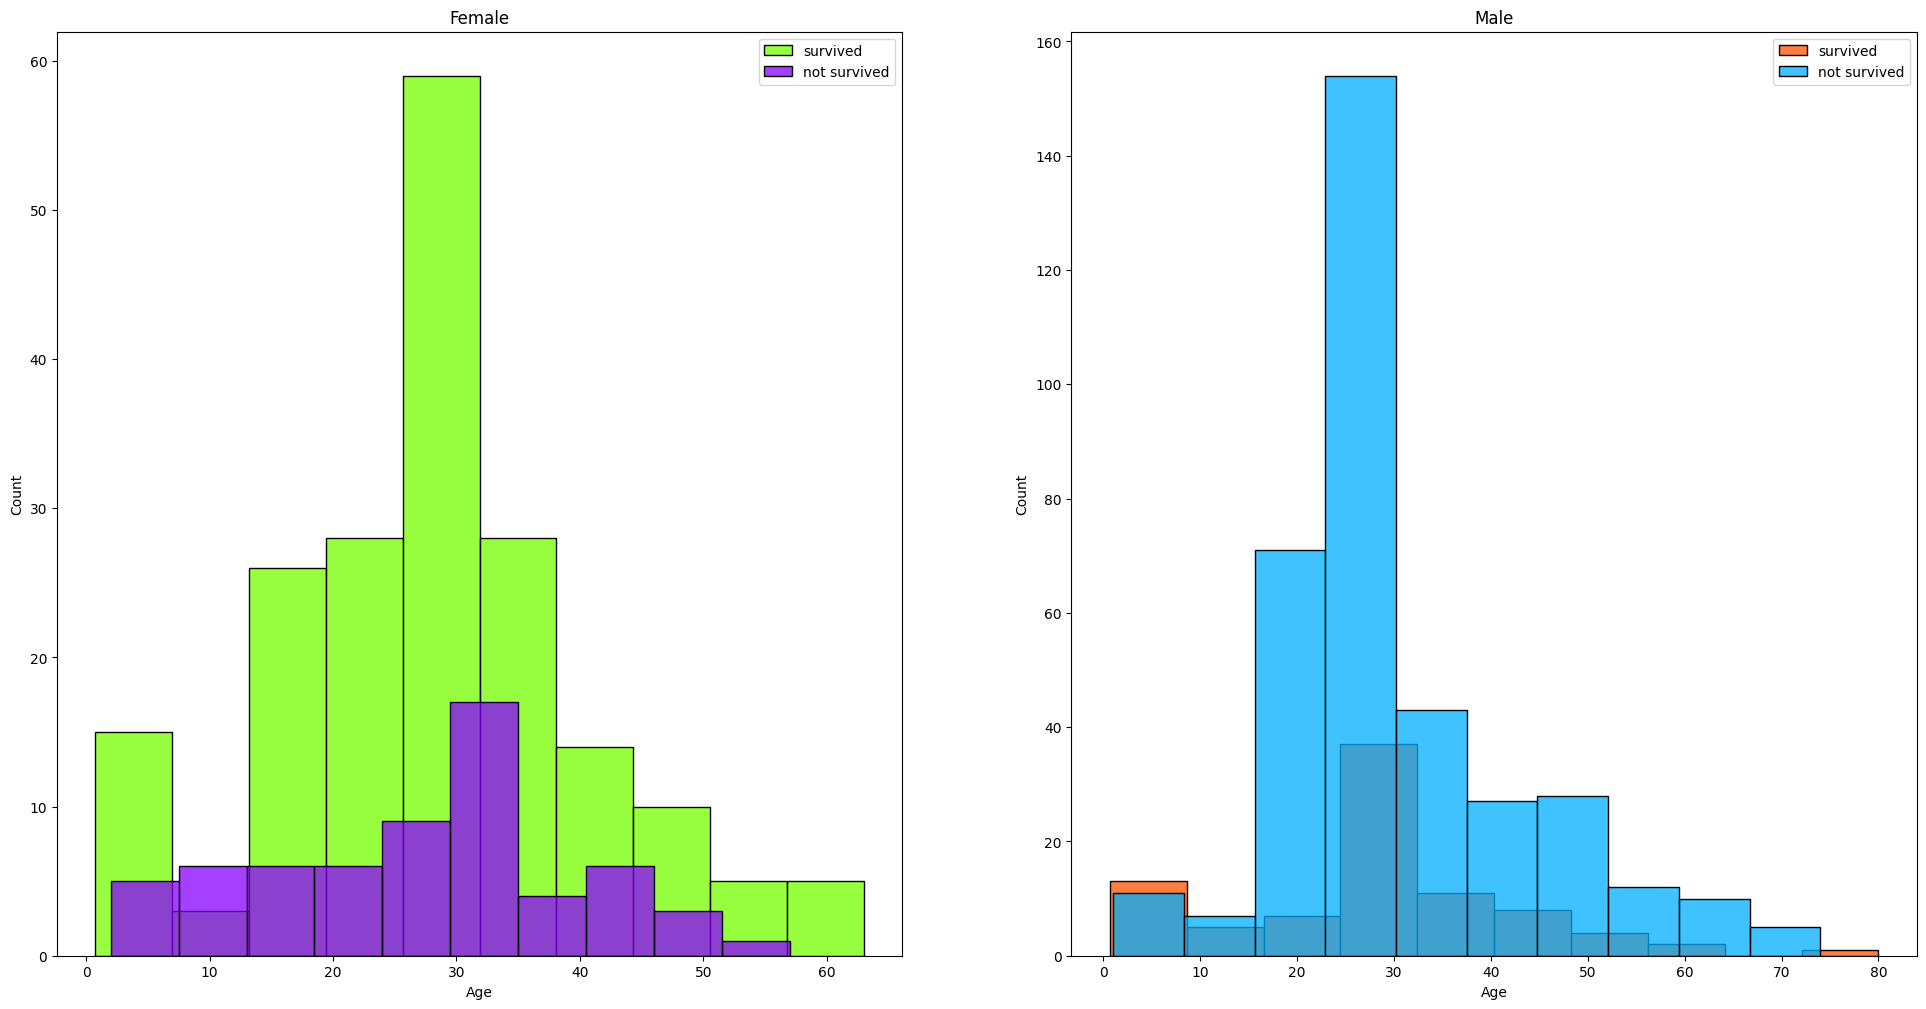

In [1755]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(24, 12))
women = train_set[train_set['Sex']==0]
men = train_set[train_set['Sex']==1]
ax = sns.histplot(women[women['Survived']==1].Age.dropna(), bins=10, label = survived, ax = axes[0], kde =False, color="#76FF00")
ax = sns.histplot(women[women['Survived']==0].Age.dropna(), bins=10, label = not_survived, ax = axes[0], kde =False, color="#8900FF")
ax.legend()
ax.set_title('Female')
ax = sns.histplot(men[men['Survived']==1].Age.dropna(), bins=10, label = survived, ax = axes[1], kde = False, color="#FF5100")
ax = sns.histplot(men[men['Survived']==0].Age.dropna(), bins=10, label = not_survived, ax = axes[1], kde = False, color="#00AEFF")
ax.legend()
_ = ax.set_title('Male')

In [1756]:
# Making DataFrame for the histogram above without age group
def createHistTable(data_frame):
        # Defining categories (survived, not survived)
        categories = ['survived', 'not survived']

        women_survived = data_frame[(data_frame["Sex"] == 1) & (data_frame["Survived"] == 1)]  # survived women
        women_not_survived = data_frame[(data_frame["Sex"] == 1) & (data_frame["Survived"] == 0)]  # non-survived women
        men_survived = data_frame[(data_frame["Sex"] == 0) & (data_frame["Survived"] == 1)]  # Ages of survived men
        men_not_survived = data_frame[(data_frame["Sex"] == 0) & (data_frame["Survived"] == 0)]  # Ages of non-survived men


        data = {'Category': ['survived men', 'survived women', 'not-survived women', 'not-survived men'], 
                'Survived': [len(men_survived), len(women_survived), len(women_not_survived), len(men_not_survived)]}


        Survivors2 = pd.DataFrame.from_dict(data, orient='index').transpose()

        return Survivors2


In [1757]:
# Creating data table for the histogram above without age group
histTable = createHistTable(train_set)
if not histTable.empty:
    display(histTable)
else:
    print("No dataframe was not found during the process")



,Category,Survived
0,survived men,193
1,survived women,88
2,not-survived women,368
3,not-survived men,63


In [1758]:
# Making DataFrame for the histogram above with age group
def createHistTableAG(data_frame):
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
    age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']

    data_frame =  data_frame.copy()
    data_frame['AgeGroup'] = pd.cut(data_frame['Age'], bins=age_bins, labels=age_labels, right=False)

    data = {
        'AgeGroup': age_labels,
        'Survived Women': [],
        'Not Survived Women': [],
        'Survived Men': [],
        'Not Survived Men': []
    }

    for age_group in age_labels:
        survived_women = len(data_frame[(data_frame['AgeGroup'] == age_group) & (data_frame['Sex'] == 0) & (data_frame['Survived'] == 1)])
        not_survived_women = len(data_frame[(data_frame['AgeGroup'] == age_group) & (data_frame['Sex'] == 0) & (data_frame['Survived'] == 0)])
        survived_men = len(data_frame[(data_frame['AgeGroup'] == age_group) & (data_frame['Sex'] == 1) & (data_frame['Survived'] == 1)])
        not_survived_men = len(data_frame[(data_frame['AgeGroup'] == age_group) & (data_frame['Sex'] == 1) & (data_frame['Survived'] == 0)])
        
        data['Survived Women'].append(survived_women)
        data['Not Survived Women'].append(not_survived_women)
        data['Survived Men'].append(survived_men)
        data['Not Survived Men'].append(not_survived_men)

    survivors_by_age = pd.DataFrame(data)

    return survivors_by_age

In [1759]:
#Creating a data table for the histogram with age group

histTableAG = createHistTableAG(train_set)
if not histTableAG.empty:
    display(histTableAG)
else:
    print("No dataframe was not found during the process")

,AgeGroup,Survived Women,Not Survived Women,Survived Men,Not Survived Men
0,0-10,16,9,15,12
1,11-20,28,8,5,44
2,21-30,75,28,33,180
3,31-40,44,7,19,59
4,41-50,18,9,9,35
5,51-60,9,2,4,23
6,61-70,3,0,2,10
7,71-80,0,0,0,5


# Feature engineering

#### For Numeric values:
#### Descriptive statistics: min, max, percentile, mean, std etc for numeric values:

In [1760]:
train_set.describe(include=np.number)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,2.294944,0.640449,29.531213,0.528090,0.384831,32.379429,0.372191,0.394663
std,0.841990,0.480206,13.188028,1.055052,0.803085,49.836074,0.649970,0.489122
min,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.750000,0.000000,22.000000,0.000000,0.000000,7.925000,0.000000,0.000000
50%,3.000000,1.000000,29.699118,0.000000,0.000000,14.500000,0.000000,0.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.275000,1.000000,1.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000,1.000000


### Check for missing Data

In [1761]:
# Lets start by finding the missing values
def checkIfDataMissed(dataFrame):
    null_columns = train_set.isnull().any()

    if null_columns.iloc[0:].all() == False:
        print("Great! we don't have any missing data")
        return True
    else:
        print("Oops! we have missing data")
        return False

In [1762]:
# Number of missing values per feature:

train_set.iloc[:].isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64

In [1763]:
# Filling all missing values with 0 if there is 

isMissed = checkIfDataMissed(train_set)

if isMissed == True:
    train_set = train_set.fillna(method = 'ffill')
    
train_set

Great! we don't have any missing data


C:\Users\Avihai Levi\AppData\Local\Temp\ipykernel_26660\3547506348.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_set = train_set.fillna(method = 'ffill')


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.000000,1,0,78.2667,1,1
1,2,0,45.000000,0,0,13.5000,0,1
2,3,1,20.000000,0,0,9.5000,0,0
3,3,1,36.000000,0,0,7.8958,0,0
4,3,1,22.000000,0,0,8.0500,0,0
...,...,...,...,...,...,...,...,...
707,1,1,54.000000,0,0,51.8625,0,0
708,3,1,14.000000,5,2,46.9000,0,0
709,2,0,6.000000,0,1,33.0000,0,1
710,2,1,29.699118,0,0,0.0000,0,0


In [1764]:
# Use the NumPy percentile() method to find the percentiles

def agePercentile(dataFrame):

    x_age = np.percentile(dataFrame["Age"], 75)
    y_age = np.percentile(dataFrame["Age"], 90)

    print(f'x_age meaning that 75% of the people on the Titanic are {x_age} years old')
    print(f'y_age meaning that 90% of the people on the Titanic are {y_age} years old')

In [1765]:
agePercentile(train_set)

x_age meaning that 75% of the people on the Titanic are 35.0 years old
y_age meaning that 90% of the people on the Titanic are 47.0 years old


In [1766]:


def SurvivedbyAge():
    counts, bins = np.histogram(train_set.Age, bins=16)
    max_bin = np.argmax(counts)

    max_bin_midpoint = (bins[max_bin] + bins[max_bin + 1]) / 2

# Plot histogram
    plt.hist(train_set.Age, bins=16)
    plt.title("Survived by Age")
    plt.xlabel("Age")
    plt.ylabel("Survived")

# Add text annotation at the maximum point
    plt.text(max_bin_midpoint, counts[max_bin], f"Max survivers: {counts[max_bin]}", ha='center', va='bottom', bbox=dict(facecolor='blue', alpha=0))

    plt.show()

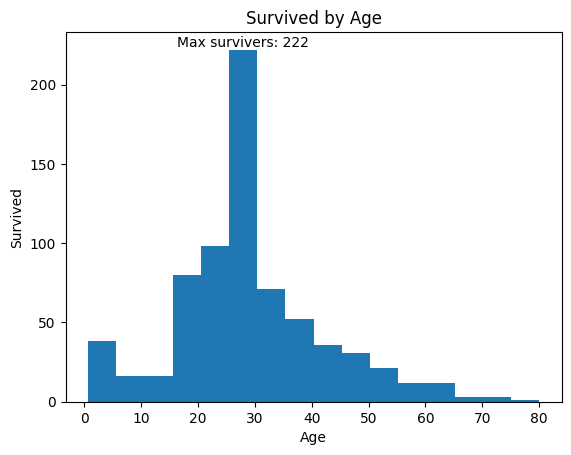

In [1767]:
SurvivedbyAge()

### Find Outliers

#### let's check for Age & Fare outliers (using boxplot)

<Axes: ylabel='Fare'>

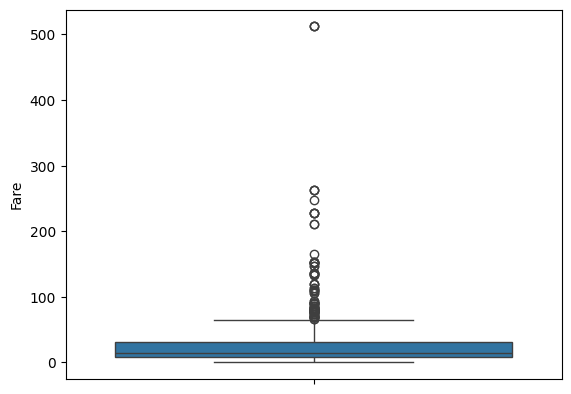

In [1768]:
# Fare outliers

sns.boxplot(train_set.Fare)

In [1769]:
train_set["Fare"].median()

14.5

In [1770]:
train_set["Fare"].describe()

count    712.000000
mean      32.379429
std       49.836074
min        0.000000
25%        7.925000
50%       14.500000
75%       31.275000
max      512.329200
Name: Fare, dtype: float64

In [1771]:
# Find Fare outliers:

# "mimimum" = Q1 - 1.5 * IQR
# "maximum" = Q3 + 1.5 * IQR


def outliersByIQR(col_name):
   
    Q1 = np.percentile(train_set[col_name], 25)
    Q3 = np.percentile(train_set[col_name], 75)
    IQR = Q3 - Q1

    Fare_Outliers = train_set[(train_set[col_name] < Q1 - 1.5*IQR) | (train_set[col_name] > Q3 + 1.5*IQR )].index
    print(f'Sum of Age_outliers: {len(Fare_Outliers)}')




In [1772]:
outliersByIQR("Fare")

Sum of Age_outliers: 93


<Axes: ylabel='Age'>

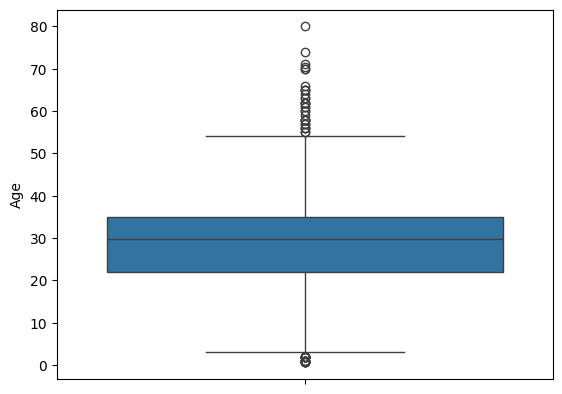

In [1773]:
# check outliers for Age

sns.boxplot(train_set.Age)

In [1774]:
train_set["Age"].median()

29.69911765

In [1775]:
train_set["Age"].describe()

count    712.000000
mean      29.531213
std       13.188028
min        0.670000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [1776]:
# Find Age outliers:
outliersByIQR("Age")


Sum of Age_outliers: 54


In [1777]:
# Let's remove outliers

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


re_dat = remove_outlier(train_set, "Fare")
re_dat = remove_outlier(train_set, "Age")

In [1778]:
print(re_dat.count())

Pclass      658
Sex         658
Age         658
SibSp       658
Parch       658
Fare        658
Embarked    658
Survived    658
dtype: int64


#### Feature engineering for Naive Bayes:

In [1779]:
#defining a training function to NB algorithm:
def nb_train(train_set):
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
    x_train = train_set[features]
    y_train = train_set['Survived']
    return x_train,y_train
x_train,y_train = nb_train(train_set)

In [1780]:
def nb_test(x_train,y_train):
    nb = GaussianNB()
    training_sizes = np.linspace(0.1, 0.9, 9)
    accuracies = []
    for size in training_sizes:
        x_train_split,x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train, train_size=size, random_state=42)
        nb.fit(x_train_split, y_train_split)
        val_predictions = nb.predict(x_val_split)
        accuracy = accuracy_score(y_val_split, val_predictions)
        accuracies.append(accuracy)
    max_accuracy = max(accuracies)
    max_index = accuracies.index(max_accuracy) #choosing the highest accuracy value from all accuracies

    return training_sizes,accuracies,max_accuracy,max_index

In [1781]:
def show_acc(training_sizes, accuracies, max_accuracy, max_index):
    plt.figure(figsize=(10, 6))
    plt.plot(training_sizes, accuracies, marker='o', linestyle='-', color='b')
    plt.annotate(
    f'Max accuracy: {max_accuracy:.3f}',
    xy=(training_sizes[max_index], accuracies[max_index]),
    xytext=(training_sizes[max_index] + 0.1, accuracies[max_index] - 0.050),
    arrowprops=dict(facecolor='orange', shrink=0.05),
    fontsize=15,
    color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

    plt.xlabel('Training Size', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
    plt.title('Validation Accuracy of Naive Bayes Classifier', fontsize=20)
    plt.grid(True)
    print(f"Max accuracy for Naive Bayes algorithm: {max_accuracy:.3f}")
    plt.show()


In [1782]:
#feature engineering by PCA and scaling (pipelining):
def create_pipeline(train_set,scaler,pca,dim):
        x_train = train_set[['Pclass','Sex','Age','SibSp','Parch','Fare']]
        steps = []
        if scaler:
                steps.append(('scaler', StandardScaler()))
        if pca:
                steps.append(('pca', PCA(n_components=dim)))
                
        pipeline = Pipeline(steps)
        fe_train = pipeline.fit_transform(x_train)
        return fe_train

   Scaler    PCA  Best Dim  Max Accuracy
0    True   True         5      0.775439
1    True  False         1      0.768421
2   False   True         6      0.782456
Max accuracy for Naive Bayes algorithm: 0.782


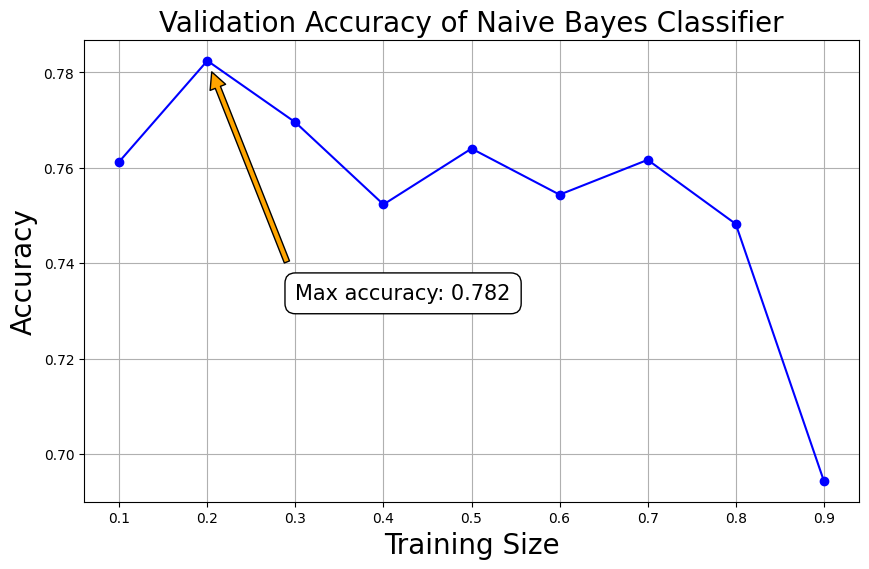

In [1783]:

# Define the combinations of parameters and the range of `dim` values
def best_fe():
    combinations = [
    (True, True),
    (True, False),
    (False, True)
]
    dim_values = range(1, len(train_set.columns) - 1 )  # Assuming we want to test dimensions from 1 to col len - 1 

# Initialize a list to store the results
    results = []
    y_train = train_set['Survived']
# Iterate over each combination and each dim value
    for scaler, pca in combinations:
        best_accuracy = 0
        best_dim = None
        for dim in dim_values:
            fe_train = create_pipeline(train_set, scaler, pca, dim)
            training_sizes, accuracies, max_accuracy, max_index = nb_test(fe_train, y_train)
        
            if max_accuracy > best_accuracy:
                best_accuracy = max_accuracy
                best_dim = dim
        
    
        results.append({
        'Scaler': scaler,
        'PCA': pca,
        'Best Dim': best_dim,
        'Max Accuracy': best_accuracy
    })

# Create a DataFrame to display the results
    results_df = pd.DataFrame(results)
    return training_sizes,accuracies,max_index,results_df

training_sizes, accuracies, max_index, results_df = best_fe()

# Display the results table
print(results_df)
best_accuracy = results_df['Max Accuracy'].max()
show_acc(training_sizes, accuracies, best_accuracy, max_index)

## Part 3 - Training flow
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 2)

In [1784]:
def min_max_scale(series, feature_range=(1, -1)):
    min_val = series.min()
    max_val = series.max()
    scale = (feature_range[1] - feature_range[0]) / (max_val - min_val)
    scaled_series = scale * (series - min_val) + feature_range[0]
    return scaled_series

## KNN training:

In [1785]:
x_train = train_set[['Pclass','Sex','Age','SibSp','Parch','Fare']]
y_train = train_set['Survived']

In [1786]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=11)

# Naive Bayes training:

In [1787]:
#defining a training function to NB algorithm:
def nb_train(train_set):
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
    x_train = train_set[features]
    y_train = train_set['Survived']
    return x_train,y_train
x_train,y_train = nb_train(train_set)
display(x_train)

,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,54.000000,1,0,78.2667
1,2,0,45.000000,0,0,13.5000
2,3,1,20.000000,0,0,9.5000
3,3,1,36.000000,0,0,7.8958
4,3,1,22.000000,0,0,8.0500
...,...,...,...,...,...,...
707,1,1,54.000000,0,0,51.8625
708,3,1,14.000000,5,2,46.9000
709,2,0,6.000000,0,1,33.0000
710,2,1,29.699118,0,0,0.0000


## Part 4 - Apply on test and show model performance estimation

## KNN algorithm testing:

In [1788]:
test_set = pd.read_csv("titanic_test.csv")

In [1789]:
x_test = test_set[['Pclass','Sex','Age','SibSp','Parch','Fare']]
y_test = test_set['Survived']

In [1790]:
y_predict = knn.predict(x_test)
accuracy = accuracy_score(y_test,y_predict)
print("accuracy: ", accuracy)

accuracy:  0.7374301675977654


In [1791]:
neighbors = np.arange(1, 100)
accuracy_scores=[]
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train,y_train)
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

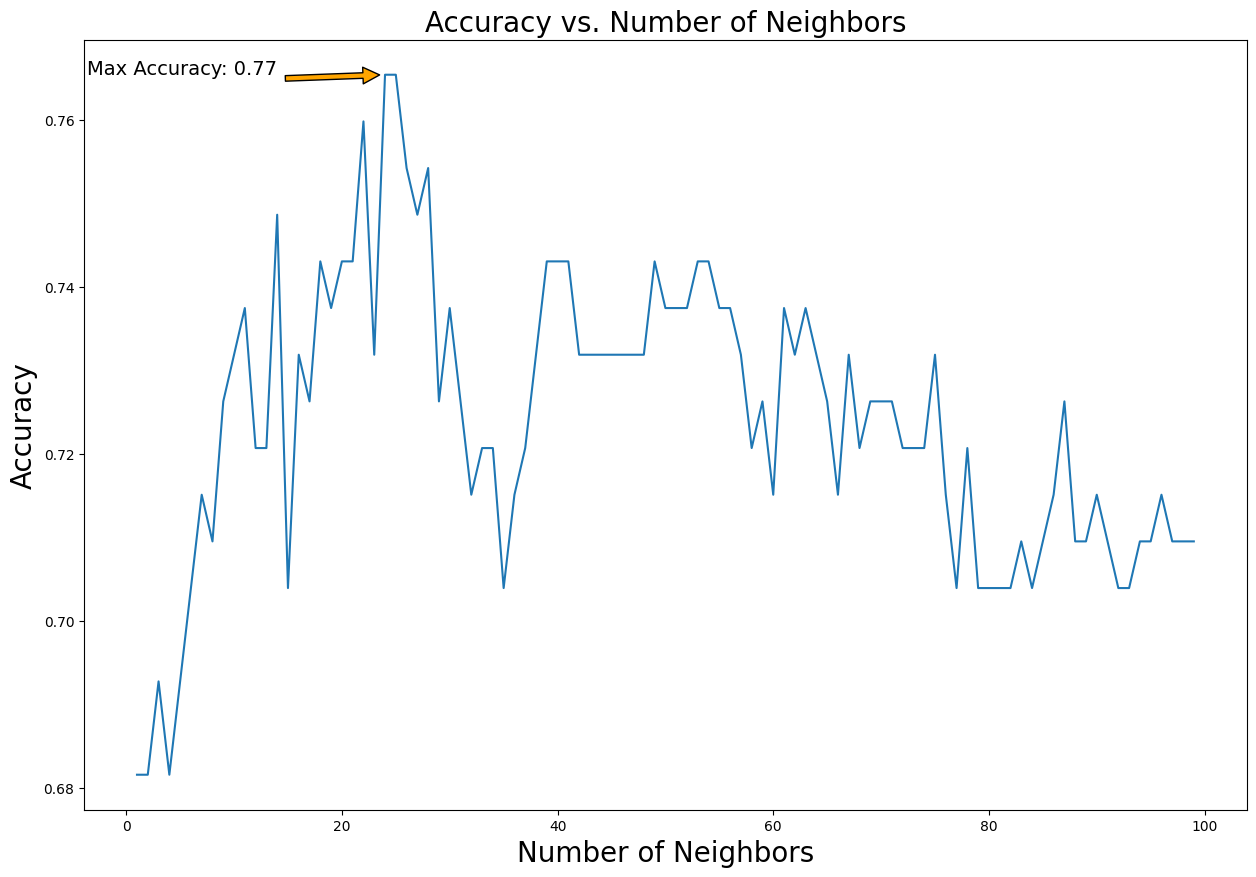

In [1792]:
plt.figure(figsize=(15, 10))
plt.plot(neighbors, accuracy_scores)
plt.xlabel('Number of Neighbors', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy vs. Number of Neighbors', fontsize=20)

# Finding the maximum accuracy and its corresponding neighbor
max_index = accuracy_scores.index(max(accuracy_scores))
max_neighbor = neighbors[max_index]
max_accuracy = accuracy_scores[max_index]

# Adding annotation
plt.annotate(f'Max Accuracy: {max_accuracy:.2f}', 
             xy=(max_neighbor, max_accuracy),  # Arrowhead position
             xytext=(max_neighbor-10, max_accuracy),  # Text position above the point
             arrowprops=dict(facecolor='orange', shrink=0.05),
             ha='right', fontsize=14)
plt.show()

## Naive Bayes algorithm testing: